In [1]:
"""
_desc_: This notebook presents a model using CNN using images from deforestation sources provided by NUWE.
__authors__: Calum Meikle and Hector Navarro 
"""

'\n_desc_:\n'

In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from keras import backend as K
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
import cv2
import time
from tensorflow import keras
import tensorflow as tf
from keras.optimizers import Adam
from keras.layers import Activation
import csv

2022-11-19 20:24:20.321100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 20:24:20.430121: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-19 20:24:20.433265: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 20:24:20.433284: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [4]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt

In [5]:
class PyteamModel:

    def __init__(self, data, resized_height=32, resized_width=32, 
                 batch_size=32, num_channels=3, epochs=10):

        self.data = data
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.resize = (self.resized_height, self.resized_width)
        self.batch_size = batch_size
        self.num_channels = num_channels
        self.epochs = epochs
        
        self.labels_dict = {
                            0: 'Plantation',
                            1: 'Grassland/Shrubland',
                            2: 'Smallholder Agriculture'
        }
        self.labels = self.labels_dict.values()

    def process_train_data(self):
        '''
        This function returns a df tagged with cases 
        '''
        self.df_train = pd.read_csv(self.data)
        self.df_train["tag"] = self.df_train["label"].replace(self.labels_dict)


    def plot_samples(self):
        '''
        this function returns a plot wiht a sample training data
        '''
        new_style = {'grid': False}
        plt.rc('axes', **new_style)
        _, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
        i = 0
        for f,l in zip(self.df_train['example_path'][:9], self.df_train['tag'][:9]):
            img = cv2.imread(f)
            ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax[i // 3, i % 3].set_title('{} - {}'.format(l , f))
            #ax[i // 4, i % 4].show()
            i += 1
            
        return plt.show()


    def load_data(self):
        '''
        Return images in array format as X_train and the labels as y_train
        '''

        X_train = []
        y_train = []

        label_map = {l: i for i, l in enumerate(self.labels)}

        for f, tags in zip(self.df_train['example_path'], self.df_train['tag']):
            img = cv2.imread(f)
            #img = self.hist(img)
            targets = np.zeros(3)
            targets[label_map[tags]] = 1 

            X_train.append(cv2.resize(img, self.resize))
            y_train.append(targets)
            
        y_train = np.array(y_train, np.uint8)
        X_train = np.array(X_train, np.float16) / 255.

        return X_train, y_train

        
    @staticmethod
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    @staticmethod
    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    @staticmethod
    def f1_score(y_true, y_pred):
        precision = PyteamModel.precision_m(y_true, y_pred)
        recall = PyteamModel.recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
    

    def choosing_model(self):

        '''
        Return a trained model
        '''

        output_model_nme = 'Best_accuracy.h5'

        my_callbacks = [
                        tf.keras.callbacks.EarlyStopping(patience=2),
                        tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/'+output_model_nme,
                        save_best_only=True, mode='max', verbose=1),
                        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
                    ]
        
        X, y = self.load_data()
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state = 20)

        model = Sequential()
        model.add(Conv2D(32, (3, 3), input_shape=(self.resized_width, self.resized_height, self.num_channels)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation('relu'))
        model.add(Dropout(0.1))
        model.add(Dense(3))
        model.add(Activation('sigmoid'))


        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', self.f1_score])
        model.summary()
        
        model_fit = model.fit(
                        X_train, y_train,
                        batch_size=self.batch_size,
                        epochs=self.epochs,
                        verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=my_callbacks
                    )

        return model_fit

    def learning_curve(self, key='accuracy', ylim=(0., 1.)):
        '''
        Return a plot with the accuracy or loss curve
        '''
        model_fit = self.choosing_model()
        
        plt.figure(figsize=(12,6))
        plt.plot(model_fit.history[key])
        plt.plot(model_fit.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
        plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
        plt.tight_layout()
        plt.savefig(key+'.png', dpi=300)
        return plt.show()

    def validate_data(self, data_path, model_path = 'saved_models/Best_accuracy.h5'):
        '''
        Return a json with predictions with new data provided
        '''
        df_tst  = pd.read_csv(data_path)
        labels = [ v for k,v in self.labels_dict.items()]
        
        X_test = []
        imagest = []
        for file in df_tst['example_path']:
            
            img = cv2.imread(file)
            
            X_test.append(cv2.resize(img, (self.resized_width, self.resized_height)))
            imagest.append(file)

        model = keras.models.load_model(model_path, custom_objects={"f1_score":  self.f1_score})
        X_test = np.array(X_test, np.float16) / 255
        y_pred = model.predict(X_test, batch_size=self.batch_size)

        with open('submission.csv', 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile, delimiter=',',
                                    quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(('image_name', 'tags'))
            for i, image in enumerate(imagest):
                csv_writer.writerow((image.split('/')[2], ''.join(np.array(labels)[(y_pred[i] == y_pred[i].max(axis=0)).astype(bool)])))
        import json
        predictions = pd.read_csv('submission.csv')

        label_dict_reverse = {
            'Plantation': 0,
            'Grassland/Shrubland': 1,
            'Smallholder Agriculture': 2,
                }
        predictions = predictions.replace(label_dict_reverse)

        predictions["target"] = [i.split(".")[0] for i in predictions["image_name"]]
        predictions = dict(zip(predictions["target"], predictions["tags"]))
        with open("predictions.json", "w") as file:
            json.dump(predictions, file, indent=4)


In [6]:
test = PyteamModel('train.csv', epochs=100, resized_width=128, resized_height=128, batch_size=16)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 61, 61, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                    

2022-11-19 20:24:28.499639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hnavarro/Desktop/Nuwe_hackaton/pyteam4def/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-19 20:24:28.499655: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-19 20:24:28.499666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hnavarro): /proc/driver/nvidia/version does not exist
2022-11-19 20:24:28.499824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, 

Epoch 1/100
86/86 [==============================] - ETA: 0s - loss: 0.9694 - accuracy: 0.4748 - f1_score: 0.5814
Epoch 1: val_loss improved from -inf to 0.87481, saving model to saved_models/Best_accuracy.h5
86/86 [==============================] - 9s 100ms/step - loss: 0.9694 - accuracy: 0.4748 - f1_score: 0.5814 - val_loss: 0.8748 - val_accuracy: 0.5335 - val_f1_score: 0.5998
Epoch 2/100
86/86 [==============================] - ETA: 0s - loss: 0.9160 - accuracy: 0.5274 - f1_score: 0.5944
Epoch 2: val_loss did not improve from 0.87481
86/86 [==============================] - 8s 94ms/step - loss: 0.9160 - accuracy: 0.5274 - f1_score: 0.5944 - val_loss: 0.8408 - val_accuracy: 0.6239 - val_f1_score: 0.6401
Epoch 3/100
86/86 [==============================] - ETA: 0s - loss: 0.8973 - accuracy: 0.5777 - f1_score: 0.5997
Epoch 3: val_loss did not improve from 0.87481
86/86 [==============================] - 8s 95ms/step - loss: 0.8973 - accuracy: 0.5777 - f1_score: 0.5997 - val_loss: 0.835

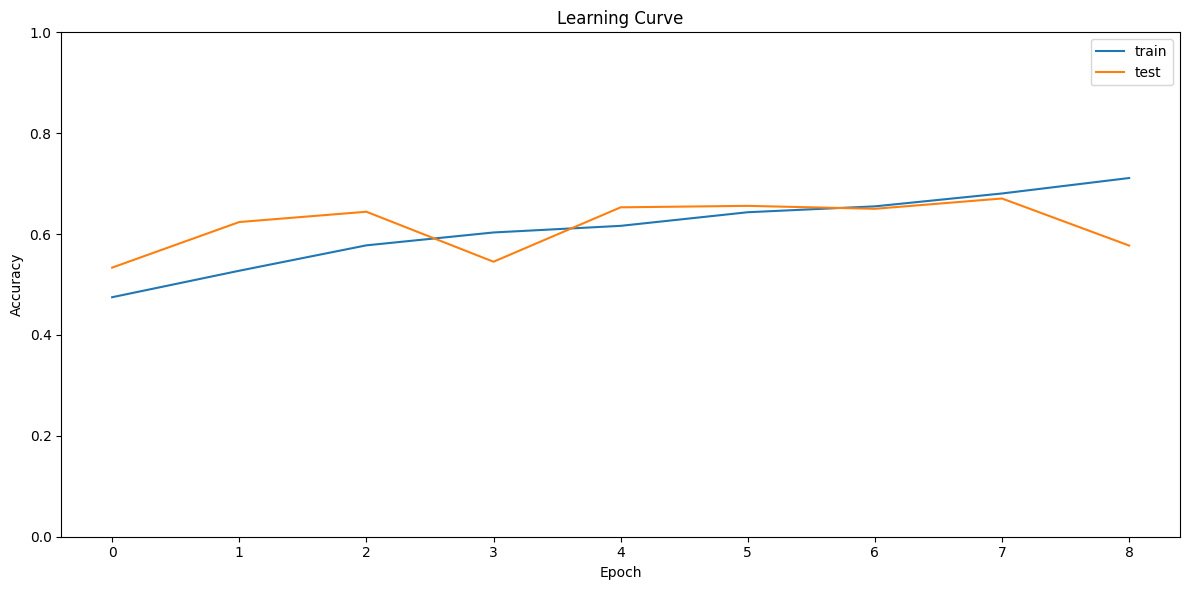

In [7]:
test.process_train_data()
test.learning_curve()

In [8]:
test.validate_data('test.csv')

40/40 [==============================] - 2s 37ms/step
